# Creating and Using `OrbitSkyOffSetFrame`

In [1]:
"""
    TITLE   : Creating and Using `OrbitOffSetFrame`
    AUTHOR  : Nathaniel Starkman
    PROJECT : Astronat tutorials
""";

__author__ = 'Nathaniel Starkman'
__version__ = 'May 13, 2020'

<span style='font-size:30px;font-weight:650'>
    About
</span>
<br><br>

Pseudo Reference Frames for positions relative to an orbit.


In [2]:
# First some imports

from utilipy import ipython  # Shameless plug

import astropy.coordinates as coords
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.pyplot as plt
import numpy as np

from galpy.orbit import Orbit
from galpy.potential import MWPotential2014

ipython.aimport("starkman_thesis")
from starkman_thesis import coordinates

set autoreload to 1
/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/astropy/coordinates/builtin_frames/galactocentric.py:373: AstropyDeprecationWarning: In v4.1 and later versions, the Galactocentric frame will adopt default parameters that may update with time. An updated default parameter set is already available through the astropy.coordinates.galactocentric_frame_defaults ScienceState object, as described in but the default is currently still set to the pre-v4.0 parameter defaults. The safest way to guard against changing default parameters in the future is to either (1) specify all Galactocentric frame attributes explicitly when using the frame, or (2) set the galactocentric_frame_defaults parameter set name explicitly. See http://docs.astropy.org/en/latest/coordinates/galactocentric.html for more information.
  AstropyDeprecationWarning)



In [3]:
# ensure clean environment by removing any caches.
starkman_thesis.coordinates.builtin_frames.orbitoffset._orbitoffset_cache.clear()

<br><br>

- - - 


## Load in Some Data

In [4]:
# Pal 5 position
pos = starkman_thesis.streams.pal5.data.Pal5latest

In [5]:
# RR-Lyrae data
tables = starkman_thesis.streams.pal5.data.get_data(table="PriceWhelanEtAl2019")
tables

# select actual stream-member stars
sel = tables[0]["Memb"] > 0.9
data = tables[0][sel]

# build phase-space table
vxvv = data["RA", "DE", "Dist", "pmRA", "pmDE"]
vxvv["Vlos"] = 0 * u.km / u.s
vxvv[:3]

TableList with 2 tables:
	'0:J/AJ/158/223/table2' with 16 column(s) and 3300 row(s) 
	'1:objs' with 11 column(s) and 135 row(s) 

RA,DE,Dist,pmRA,pmDE,Vlos
deg,deg,kpc,mas / yr,mas / yr,km / s
float64,float64,float32,float32,float32,float64
229.039575298,-0.273152598,21.24,-2.893,-2.692,0.0
228.992666258,-0.096598048,20.73,-2.812,-2.654,0.0
226.199350587,-3.377018582,19.82,-2.705,-3.080,0.0


In [6]:
# build phase-space error table

e_Dist = data["Plx"].to(u.kpc, equivalencies=u.parallax()) * (data["e_Plx"] / data["Plx"])
sel_dist = np.isfinite(e_Dist)

vxvv_err = data["e_RA", "e_DE"]
vxvv_err["e_Dist"] = e_Dist
vxvv_err["e_pmRA"] = data["e_pmRA"]
vxvv_err["e_pmDE"] = data["e_pmDE"]
vxvv_err["e_Vlos"] = np.inf * u.km / u.s

vxvv = vxvv[sel_dist]  # need to modify vxvv table b/c Nans :(
vxvv_err = vxvv_err[sel_dist]

/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/astropy/units/equivalencies.py:88: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / x

/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



Make Orbits

In [7]:
# forward
o_fwd = Orbit(vxvv=pos.vxvv)
t_fwd = np.linspace(0, 100, num=10000) * u.Myr
o_fwd.integrate(t=t_fwd, pot=MWPotential2014)
sc_fwd = o_fwd.SkyCoord(t_fwd)

# backward
o_bkw = Orbit(vxvv=pos.vxvv)
t_bkw = np.linspace(0, -100, num=10000) * u.Myr
o_bkw.integrate(t=t_bkw, pot=MWPotential2014)
sc_bkw = o_bkw.SkyCoord(t_bkw[::-1])

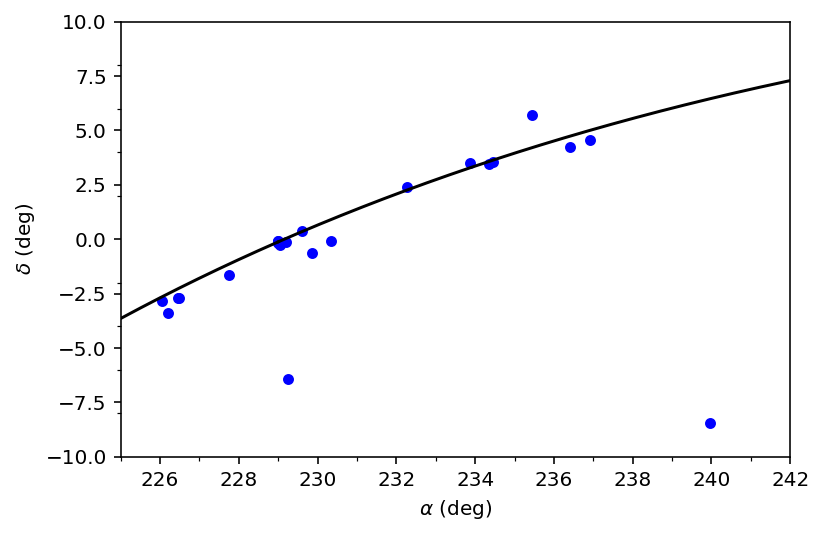

In [8]:
o_fwd.plot(d1='ra', d2='dec', c='k')
o_bkw.plot(d1='ra', d2='dec', c='k', overplot=True)

plt.scatter(data["RA"], data["DE"], s=20, c='blue')
plt.xlim((225, 242))
plt.ylim((-10, 10))
plt.show();

## Orbit Offsets

In [9]:
vxvv_sc = SkyCoord(ra=vxvv["RA"], dec=vxvv["DE"],
             distance=vxvv["Dist"]
)

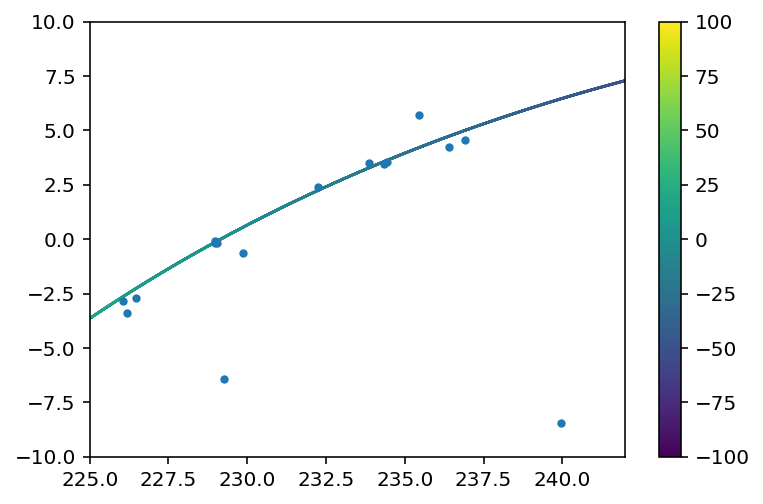

In [10]:
# affine parameter
orbit_time_param = [*t_bkw[::-1], *t_fwd] << u.Myr

# create single catalog
orbit_catalog = coords.concatenate([sc_bkw.frame, sc_fwd.frame])

# plot
line = plt.scatter(orbit_catalog.ra.value, orbit_catalog.dec.value,
                   c=orbit_time_param.value, s=0.1)
plt.scatter(vxvv["RA"], vxvv["DE"], s=10)
plt.colorbar(line)
plt.xlim((225, 242))
plt.ylim((-10, 10))
plt.show();

Construct an orbit reference from from the galpy Orbit.

In [13]:
frame = starkman_thesis.coordinates.OrbitOffsetFrame.from_galpy_orbit(
    orbit=o_fwd, orbit_bkw=o_bkw, frame="icrs", time_unit=u.Myr, method="linear", inverse_track_fn_kw={"tol": 1}
)

frame

<OrbitOffsetICRS Frame (potential=[<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff object at 0x1180d9090>, <galpy.potential.MiyamotoNagaiPotential.MiyamotoNagaiPotential object at 0x1185afc90>, <galpy.potential.TwoPowerSphericalPotential.NFWPotential object at 0x1185afc50>], afn_bounds=[-100.  100.] Myr, origin=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (229., -0.124, 22.9)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-2.296, -2.257, -58.7)>)>

Transform the coordinates to this reference frame.

In [27]:
orbit_catalog.cartesian.without_differentials()

<CartesianRepresentation (x, y, z) in kpc
    [(-3.76298283, -19.95664599,  3.86126337),
     (-3.76465613, -19.95722819,  3.86137322),
     (-3.76632935, -19.95781017,  3.86148294), ...,
     (-7.72666912,  -3.65762678, -8.35292765),
     (-7.72435092,  -3.65622488, -8.35351696),
     (-7.72203228,  -3.65482315, -8.35410608)]>

In [59]:
from astropy.coordinates import match_coordinates_sky, match_coordinates_3d

def catalog_match_track(
    coords, catalog, affine_param, adj_sep_sgn=True,
):
    idx, _, _, = match_coordinates_3d(coords, catalog)
    afn = affine_param[idx]

    # now project onto plane orthogonal to curve
    # TODO more rigorous tangent vector method
    cart = catalog.cartesian.without_differentials()  # TODO, not need
    tvec = cart[idx + 1] - cart[idx - 1]  # tangent vector
    that = tvec / tvec.norm()
    
    # TODO use astropy matrix utilities, like rotation

    # define vectors along curve from central point
    delta2 = cart[idx + 1] - cart[idx]
    delta1 = cart[idx - 1] - cart[idx]

    fac = that.dot(delta1) / that.dot(delta2)

    xvec = delta1 - fac * delta2
    xhat = xvec / xvec.norm()

    yvec = that.cross(xvec)
    yhat = yvec / yvec.norm()

    # basic projection
    # https://en.wikipedia.org/wiki/Vector_projection
    x = cart[idx].dot(xhat)
    y = cart[idx].dot(yhat)
    # and error in projection
    d_afn = cart[idx].dot(that)

    return xvec
#     return afn, x, y, d_afn


# /def

xvec = catalog_match_track(vxvv_sc, orbit_catalog, orbit_time_param, True)
xvec

<CartesianRepresentation (x, y, z) in kpc
    [(1.96962594e-07,  5.39800770e-08, -2.40580916e-09),
     (2.03005588e-07,  1.63299532e-08,  2.50166339e-08),
     (1.95958514e-07,  5.76543003e-08, -5.16166157e-09),
     (1.98126464e-07,  4.92442436e-08,  1.12166816e-09),
     (1.97177291e-07,  5.31486403e-08, -1.78456447e-09),
     (1.61179436e-07,  1.17894107e-07, -5.37423095e-08),
     (1.77231028e-07,  9.83370770e-08, -3.70927254e-08),
     (2.02788196e-07,  1.88253560e-08,  2.32355950e-08),
     (1.60232653e-07,  1.18842231e-07, -5.45803881e-08),
     (2.03121249e-07,  1.49110927e-08,  2.60275647e-08),
     (1.43263391e-07,  1.33230677e-07, -6.77770089e-08),
     (1.64831972e-07,  1.14056827e-07, -5.03830921e-08),
     (1.34624477e-07,  1.39053646e-07, -7.34426951e-08),
     (2.04582021e-07, -1.08314261e-08,  4.42143375e-08),
     (2.04460525e-07, -8.15894114e-09,  4.23357251e-08),
     (1.43736765e-07,  1.32886146e-07, -6.74486893e-08),
     (1.94492614e-07,  6.24915093e-08, -8.8169

In [14]:
new_c = vxvv_sc.transform_to(frame)
new_c

TypeError: unsupported operand type(s) for *: 'CartesianRepresentation' and 'CartesianRepresentation'

In [ ]:
plt.scatter(new_c.afn, new_c.sep)
plt.xlabel(f"time [{new_c.afn.unit}]")
plt.ylabel(f"angular separation [{new_c.sep.unit}]")
plt.show();

And this can be transformed back

In [ ]:
back_c = new_c.transform_to("icrs")

plt.figure(figsize=(10, 5))
plt.scatter(back_c.ra, back_c.dec, c="r")
line = plt.scatter(orbit_catalog.ra.value, orbit_catalog.dec.value,
                   c=orbit_time_param.value, s=0.1)
plt.scatter(vxvv["RA"], vxvv["DE"], s=10)
plt.xlim((225, 242))
plt.ylim((-10, 10))
plt.show();

In [ ]:
vxvv_sc
back_c

## Transforming Between OrbitSkyOffsetFrames

it works.

In [ ]:
pos2 = pos.vxvv.replicate(copy=True)
pos2.data.x[()] = pos2.data.x + (1 * u.kpc)
pos2.cache.clear()

pos2 = SkyCoord(pos2)

In [ ]:
# forward
o2_fwd = Orbit(vxvv=pos2)
t2_fwd = np.linspace(0, 100, num=10000) * u.Myr
o2_fwd.integrate(t=t2_fwd, pot=MWPotential2014)
sc2_fwd = o2_fwd.SkyCoord(t2_fwd)

# backward
o2_bkw = Orbit(vxvv=pos2)
t2_bkw = np.linspace(0, -100, num=10000) * u.Myr
o2_bkw.integrate(t=t2_bkw, pot=MWPotential2014)
sc2_bkw = o2_bkw.SkyCoord(t_bkw[::-1])

In [ ]:
plt.figure(figsize=(10, 5))
o_fwd.plot(d1='ra', d2='dec', c='k', overplot=True)
o_bkw.plot(d1='ra', d2='dec', c='k', overplot=True)

o2_fwd.plot(d1='ra', d2='dec', c='k', ls="--", overplot=True)
o2_bkw.plot(d1='ra', d2='dec', c='k', ls="--", overplot=True)

plt.scatter(data["RA"], data["DE"], s=20, c='blue')
plt.xlim((225, 242))
plt.ylim((-10, 10))
plt.show();

In [ ]:
frame2 = starkman_thesis.coordinates.OrbitSkyOffsetFrame.from_galpy_orbit(
    orbit=o2_fwd, orbit_bkw=o2_bkw, frame="icrs", time_unit=u.Myr
)

frame2

In [ ]:
new_c.transform_to(frame)

In [ ]:
new_c2 = new_c.transform_to(frame2)
new_c2

In [ ]:
# new_c2.frame.data.time

In [ ]:
plt.scatter(new_c.afn, new_c.sep, alpha=0.5, label="Orbit 1")
plt.scatter(new_c2.afn, new_c2.sep, label="Orbit 2")
plt.xlabel(f"time [{new_c2.afn.unit}]")
plt.ylabel(f"angular separation [{new_c2.sep.unit}]")

plt.tight_layout()
plt.legend()
plt.show();

In [ ]:
back_c2 = new_c2.transform_to("icrs")

plt.figure(figsize=(10, 5))
plt.scatter(back_c2.ra, back_c2.dec, c="r")
line = plt.scatter(orbit_catalog.ra.value, orbit_catalog.dec.value,
                   c=orbit_time_param.value, s=0.1)
plt.scatter(vxvv["RA"], vxvv["DE"], s=10)

o2_fwd.plot(d1='ra', d2='dec', c='k', ls="--", overplot=True)
o2_bkw.plot(d1='ra', d2='dec', c='k', ls="--", overplot=True)
plt.show();

## Some Details

In [ ]:
# Attributes
pa = starkman_thesis.coordinates.attributes.PotentialAttribute()
pa.convert_input(MWPotential2014[0])

In [ ]:
# representations
rep = starkman_thesis.coordinates.representations.OrbitSkyOffsetRepresentation(
    10*u.Myr, 2*u.deg, coords.Distance(parallax=2*u.mas), afn_name="time"
)
rep

rep.time

In [ ]:
# from astropy.coordinates import match_coordinates_sky

# idx, sep2d, _, = match_coordinates_sky(
#     vxvv_sc, orbit_catalog
# )
# time = orbit_time_param[idx]
# print(idx)

# sub = [5, 6]
# sidx = idx[sub]
# plt.figure(figsize=(10,4))
# plt.scatter(orbit_catalog[sidx].ra, orbit_catalog[sidx].dec, c=range(len(vxvv_sc[sub])), vmax=len(vxvv_sc[sub]), s=10)
# plt.scatter(orbit_catalog[sidx+10].ra, orbit_catalog[sidx+10].dec, c="k", s=5)
# plt.scatter(vxvv_sc[sub].ra, vxvv_sc[sub].dec)
# plt.colorbar()

# theta1 = orbit_catalog[idx].position_angle(vxvv_sc) * u.dimensionless_unscaled  # convert to quantity list
# theta2 = orbit_catalog[idx+1].position_angle(vxvv_sc) * u.dimensionless_unscaled  # convert to quantity list

# sep2d[sub] *= (theta2[sub].value - theta1[sub].value)
# print(sep2d[sub])

# plt.show();

In [ ]:
import astropy
astropy._yourfuture("2000-01-01")